### Imports

In [90]:
from enum import Enum
from typing import List, Tuple

import gymnasium
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

ALPHA_VALUE = 0.7
TEXT_FONT_SIZE = 10


def create_environment(env_name: str):
    """Create a Gymnasium environment.

    Args:
        env_name (str): Name of the environment

    Returns:
        gymnasium.Env: Gymnasium environment
    """
    env = gymnasium.make(
        env_name,
        is_slippery=False,
        render_mode="rgb_array",
    )
    return env


def generate_interpolation_factors(
    img: np.ndarray, matrix: np.ndarray
) -> Tuple[int, int]:
    """
    Generates the interpolation factors for a given matrix.
    """
    return img.shape[0] // matrix.shape[0], img.shape[1] // matrix.shape[1]


def generate_checkerboard(
    img: np.ndarray, v: np.ndarray
) -> Tuple[np.ndarray, Tuple[int, int]]:
    """
    Generates a checkerboard pattern by mapping matrix V onto image img.
    """
    interpolation_factor_x, interpolation_factor_y = generate_interpolation_factors(
        img, v
    )

    # Broadcasting the smaller matrix V to the size of img
    checkerboard = np.repeat(
        np.repeat(v, interpolation_factor_y, axis=0), interpolation_factor_x, axis=1
    )

    return checkerboard, (interpolation_factor_x, interpolation_factor_y)


def generate_colormap():
    """
    Generates a default colormap.
    """
    return LinearSegmentedColormap.from_list(
        "custom_cmap", [(0, "red"), (0.5, "white"), (1, "green")]
    )


def add_labels(
    ax, shape: Tuple[int, int], labels: List, interpolation_factors: Tuple[int, int]
):
    """
    Adds labels to the cells of the visualization.
    Parameters:
        ax (matplotlib.axes.Axes): The axes on which to add labels.
        shape (tuple): The shape of the grid.
        labels (list): The labels to add.
        interpolation_factors (tuple): The interpolation factors for positioning labels.
    """
    for i in range(shape[0]):
        for j in range(shape[1]):
            ax.text(
                interpolation_factors[0] * (j + 0.5),
                interpolation_factors[1] * (i + 0.5),
                labels[i, j],
                ha="center",
                va="center",
                fontsize=TEXT_FONT_SIZE,
                fontweight="bold",
                alpha=ALPHA_VALUE,
            )


def visualize_v(env, v: np.ndarray, ax, title: str) -> None:
    """Visualizes the value function v of the given environment."""
    v = v.reshape(env.unwrapped.desc.shape)
    v_img, interp_factors = generate_checkerboard(env.render(), v)
    v_img = ax.imshow(v_img, cmap=generate_colormap(), alpha=0.5)

    labels = np.vectorize(lambda x: f"{x:.2f}")(v)

    add_labels(ax, env.unwrapped.desc.shape, labels, interp_factors)

    visualize_env(env, ax, title)


def visualize_p(
    env, v: np.ndarray, p: np.ndarray, action: Enum, ax, title: str
) -> None:
    """Visualizes the policy p and the of the given environment."""
    if v is None:
        interp_factors = generate_interpolation_factors(
            env.render(), p.reshape(env.unwrapped.desc.shape)
        )
    else:
        v = v.reshape(env.unwrapped.desc.shape)
        v_img, interp_factors = generate_checkerboard(env.render(), v)
        v_img = ax.imshow(v_img, cmap=generate_colormap(), alpha=0.5)

    s = np.arange(env.unwrapped.observation_space.n)
    labels = np.vectorize(lambda x: action(p[x]).name)(s).reshape(
        env.unwrapped.desc.shape
    )

    add_labels(ax, env.unwrapped.desc.shape, labels, interp_factors)

    visualize_env(env, ax, title)


def visualize_env(env, ax, title: str) -> None:
    """
    Visualizes the FrozenLake environment.
    """
    ax.imshow(env.render(), alpha=ALPHA_VALUE)

    ax.axis("off")
    ax.set_title(title)


class DPType(Enum):
    """
    Enum for the different types of dynamic programming.
    """

    VALUE_ITERATION = 0
    POLICY_ITERATION = 1

In [91]:
from typing import Tuple, List
from enum import Enum

# Python imports
import random
import heapq
import collections

# Reinforcement Learning environments
import gymnasium as gym

# Scientific computing
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Define the default figure size
plt.rcParams["figure.figsize"] = [16, 4]

# Reinforcement Learning with Gym

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Reinforcement_learning_diagram.svg/300px-Reinforcement_learning_diagram.svg.png).

## Introduction

Reinforcement Learning is a special form of machine learning, where an agent interacts with an environment, conducts observations on the effects of actions and collects rewards.

The goal of reinforcement learning is to learn an optimal policy, so that given a state an agent is able to decide what it should do next.

In today's workshop we will look into three fundamental algorithms that are capable of solving MDPs, namely [Policy Iteration](https://en.wikipedia.org/wiki/Markov_decision_process#Policy_iteration), [Value Iteration](https://en.wikipedia.org/wiki/Markov_decision_process#Value_iteration), and [Q-Learning](https://en.wikipedia.org/wiki/Q-learning).

## Objectives

After this workshop you should know:

- The relevant pieces for a reinforcement learning system
- The basics of *[gym](https://gym.openai.com/envs/#classic_control)* to conduct your own RL experiments
- The differences of value and policy iteration compared with Q-Learning
- How Q-Learning converges towards a stable policy

## Preliminaries
The following section is based on the de facto standard [Reinforcement Learning: An Introduction
](http://incompleteideas.net/book/the-book-2nd.html) by Sutton and Barto.

### Markov Decision Process (MDP)
An MDP is defined by a tuple $\left\langle\mathcal{S}, \mathcal{A}, \mathcal{P}_{s s^{\prime}}^a, \mathcal{R}_s^a\right\rangle$, with:
- $\mathcal{S}$ being the finite state space,
- $\mathcal{A}$ being the finite action space,
- $\mathcal{P}_{s s^{\prime}}^a=\mathbb{P}\left[s^{\prime} \mid a, s\right]$ being the model of the probability to transition to $s^{\prime}$ when taking action $a$ in state $s$,

- $\mathcal{R}_s^a=\mathbb{E}[r \mid a, s]$ being the model of the expected reward received when taking action $a$ in state $s$.

![MPD](mdp.png "MDP")

### Trajectory
The trajectory is defined by a sequence of states and actions as a path through an MDP as

$\tau=\left(s_0, a_0, s_1, a_1, \ldots, s_T\right).$

### Return
The return $G$ of a trajectory $\tau$ equals its accumulated discounted reward at time step $t$, taking action $a_t$ in state $s_t$, defined as

$
G(\tau)=\sum_{\left(s_t, a_t\right) \in \tau} \gamma^t \mathcal{R}_{s_t}^{a_t}.
$

$\gamma$ is the discount factor, which is a value between 0 and 1, that determines the importance of future rewards.

### Policy
The policy $\pi$ is a probability distribution over actions $a \in \mathcal{A}(s)$, defined as

$
\pi=\pi(a \mid s)
$

The optimal policy $\pi^*(a \mid s)$ is a policy that yields the highest state value and state-action value of all policies.

$
\begin{aligned}
V^*(s) & \geq V^\pi(s) & & \forall s \in \mathcal{S} \\
Q^*(s, a) & \geq Q^\pi(s, a) & & \forall s \in \mathcal{S}, \forall a \in \mathcal{A}(s)
\end{aligned}
$

### State Value
The recursive form of the state value $V^\pi(s)$ with an arbitrary policy $\pi$, is defined as

$
V^\pi(s)=\sum_{a \in \mathcal{A}} \pi(a \mid s)\left(\mathcal{R}_s^a+\gamma \sum_{s^{\prime} \in \mathcal{S}} \mathcal{P}_{s s^{\prime}}^a V^\pi\left(s^{\prime}\right)\right) .
$

The recursive form of the state value $V^*(s)$ with the optimal policy, is defined as

$
V^*(s)=\max _{a \in \mathcal{A}}\left(\mathcal{R}_s^a+\gamma \sum_{s^{\prime} \in \mathcal{S}} \mathcal{P}_{s s^{\prime}}^a V^*\left(s^{\prime}\right)\right) .
$

### State-Action Value
The recursive form of the state-action value $Q^\pi(s, a)$ with an arbitrary policy $\pi$, is defined as

$
Q^\pi(s, a)=\mathcal{R}_s^a+\gamma \sum_{s^{\prime} \in \mathcal{S}} \mathcal{P}_{s s^{\prime}}^a \sum_{a^{\prime} \in \mathcal{A}} \pi\left(a^{\prime} \mid s^{\prime}\right) Q^\pi\left(s^{\prime}, a^{\prime}\right) .
$

The recursive form of the state-action value $Q^*(s, a)$ with the optimal policy, is defined as

$
Q^*(s, a)=\mathcal{R}_s^a+\gamma \sum_{s^{\prime} \in \mathcal{S}} \mathcal{P}_{s s^{\prime}}^a \max _{a^{\prime} \in \mathcal{A}} Q^*\left(s^{\prime}, a^{\prime}\right) .
$

The equations provided describe the general cases of the state-value and state-action-value functions for both arbitrary and optimal policies in a stochastic environment. In a deterministic environment, some simplifications can be made, as the probabilities involved are either 0 or 1.

This simplifies the equations for the state-value and state-action-value functions.

#### Deterministic State Value

For a deterministic environment, the transition probabilities $\mathcal{P}_{s s^{\prime}}^a$ are either 0 or 1, reflecting that there's a certain next state $s^{\prime}$ for every state-action pair $(s, a)$. Also, the policy $\pi(a | s)$ becomes deterministic, picking a single action with probability 1.

The recursive form of the state value function under an arbitrary deterministic policy $pi$ becomes:

$ V^\pi(s) = \mathcal{R}_s^{\pi(s)} + \gamma V^\pi\left(f(s, \pi(s))\right) $

where $\pi(s)$ is the action chosen by policy $\pi$ in state $s$, and $f(s, \pi(s))$ is the deterministic transition function giving the next state.

The recursive form of the state value function under the optimal policy becomes:

$ V^*(s) = \max_{a \in \mathcal{A}}\left(\mathcal{R}_s^a + \gamma V^*\left(f(s, a)\right)\right) $

#### Deterministic State-Action Value

Similar simplifications apply. The recursive form of the state-action value function under an arbitrary deterministic policy $\pi$ becomes:

$ Q^\pi(s, a) = \mathcal{R}_s^a + \gamma Q^\pi\left(f(s, a), \pi(f(s, a))\right) $

And under the optimal policy:

$ Q^*(s, a) = \mathcal{R}_s^a + \gamma \max_{a^{\prime} \in \mathcal{A}} Q^*\left(f(s, a), a^{\prime}\right) $

These simplifications essentially reflect the deterministic nature of the environment and the policy, removing the summations over states and actions that are present in the stochastic case.

### Environment | [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/#frozen-lake)

Winter has arrived. You and your friends are by the lake, its surface mostly ice-covered. However, a few spots where the ice has thinned reveal the cold water beneath. Amidst the frosty expanse, an exciting object catches your eye on the lake, and you feel an urge to pick it up.

![Frozen Lake](frozen_lake_dalle3.png "Frozen Lake")

Create and visualize the desired environment with the selected name. You can choose between the following environments: `FrozenLake-v1` and `FrozenLake8x8-v1`, the latter being a larger version of the former.

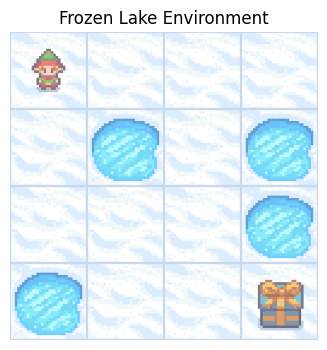

In [92]:
env = create_environment("FrozenLake-v1")

env.reset()
_, ax = plt.subplots()
visualize_env(env, ax=ax, title="Frozen Lake Environment")

#### Understanding the Environment (Object)

**TODO :**
Analyze the environment object and figure out its *observation/state-* and *actionspace* as well as its *reward range*.

What is the size of the observation/state space?

In [93]:
env.observation_space

Discrete(16)

What is the size of the action space?

In [94]:
env.action_space

Discrete(4)

What is the range of rewards?

In [95]:
env.reward_range

(0, 1)

#### Define the Action Space

When designing Reinforcement Learning agents, defining a clear and manageable action space is essential. Utilizing Python's `Enum` class for this purpose is beneficial for several reasons:

1. **Readability**: Actions can be referred to by descriptive names instead of numeric values.
2. **Maintainability**: If the action space changes, using named actions can help prevent errors from magic numbers.
3. **Flexibility**: Enumerations can be iterated over, allowing for easy examination and manipulation of the action space.

Below, we define an `Action` enumeration representing the possible moves in the FrozenLake environment:

In [96]:
class Action(Enum):
    """
    An enumeration for the possible actions in the FrozenLake environment.
    """

    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3


for action in Action:
    print("{:10} = {}".format(action.name, action.value))

LEFT       = 0
DOWN       = 1
RIGHT      = 2
UP         = 3


In Reinforcement Learning, interacting with the environment is a core concept. When an agent takes an action, the environment responds by transitioning to a new state and providing a reward. It's essential to understand this dynamic to design effective agents.


Let's analyze the action space of the environment and what happens when we take an action.

*Initial State:* We'll reset the environment to its initial state and display it.

*Action Exploration:*
- For each action in our action space: 
    - We'll reset the environment to its starting state to ensure consistency.
    - Take the action and observe the new state, reward, and whether the episode is done.

the initial state is: 0
executing action 0, should go LEFT
new state is: 0 done: False
executing action 1, should go DOWN
new state is: 4 done: False
executing action 2, should go RIGHT
new state is: 1 done: False
executing action 3, should go UP
new state is: 0 done: False


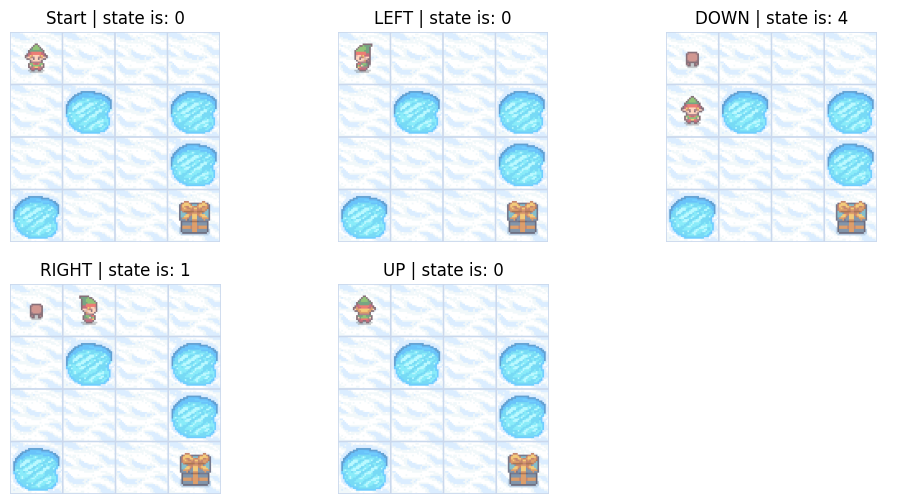

In [97]:
_, axs = plt.subplots(2, 3, figsize=(12, 6))

s, _ = env.reset()
print(f"the initial state is: {s}")
visualize_env(env, ax=axs[0, 0], title=f"Start | state is: {s}")

axs = axs.reshape(-1)[1:]
axs[-1].axis("off")

for action, ax in zip(Action, axs):
    env.reset()
    # skip the first axis
    print(f"executing action {action.value}, should go {action.name}")
    s1, r, d, _, _ = env.step(action.value)
    print(f"new state is: {s1} done: {d}")
    visualize_env(env, ax=ax, title=f"{action.name} | state is: {s1}")

#### Policy and Value Iteraton Parameters

In [98]:
MAX_ITERATIONS = (
    1000  # Max number of iterations to run the algorithms for (to avoid infinite loops)
)
DISCOUNT_FACTOR = 0.95  # Discount factor to compute the return for a trajectory (gamma)

#### Policy Return
The trajectory generated by a policy $\pi$ is defined as $\tau^\pi=\left(s_0, a_0, s_1, a_1, \ldots, s_T\right)$. Based on it we can evaluate the policy by computing the total return $G(\tau^\pi)$, which allows us to compare different policies.

$
G(\tau^\pi)=\sum_{\left(s_t, a_t\right) \in \tau} \gamma^t \mathcal{R}_{s_t}^{a_t}.
$

In [99]:
def calculate_policy_return(env, policy: np.ndarray, discount_factor: float) -> float:
    """Evaluates a policy by running it until termination and collect its reward"""
    state, _ = env.reset()
    total_return = 0.0
    step = 0
    done = False
    while not done:
        state, reward, done, *_ = env.step(policy[state])
        #### TODO: Calculate the total return of the episode
        total_return += discount_factor**step * reward
        step += 1
    return total_return

## Policy Evaluation

In [100]:
CONVERGENCE_THRESHOLD = 1e-4


def policy_evaluation(
    env, policy: np.ndarray, discount_factor: float, dp_type: DPType
) -> Tuple[np.ndarray, int]:
    """Iteratively evaluate the value function under the given policy"""
    # Initialize the state value function with zeros
    v = np.zeros(env.observation_space.n)
    iteration = 0
    while True:
        iteration += 1
        # Copy the state value function to check for convergence and avoid mixing old and new values in the updates
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            if dp_type == DPType.POLICY_ITERATION:
                v[s] = evaluate_action(env, s, prev_v, policy, discount_factor)
            elif dp_type == DPType.VALUE_ITERATION:
                v[s] = evaluate_max_action(env, s, prev_v, discount_factor)
        if value_functions_converged(v, prev_v):
            break
    return v, iteration


def evaluate_action(
    env,
    s: int,
    prev_v: np.ndarray,
    policy: np.ndarray,
    discount_factor: float,
) -> float:
    # Retrieve the action under the current policy
    a = policy[s]
    (
        expected_reward,
        expected_discounted_return,
    ) = calculate_expected_reward_and_discounted_return(
        env, s, a, prev_v, discount_factor
    )
    # Calculate the v value
    return expected_reward + expected_discounted_return


def evaluate_max_action(
    env, s: int, prev_v: np.ndarray, discount_factor: float
) -> float:
    # Initialize the action value function
    q = np.zeros([env.observation_space.n, env.action_space.n])
    # Iterate over each action
    for a in range(env.action_space.n):
        (
            expected_reward,
            expected_discounted_return,
        ) = calculate_expected_reward_and_discounted_return(
            env, s, a, prev_v, discount_factor
        )
        # Calculate the Q-Value
        q[s, a] = expected_reward + expected_discounted_return
    ### TODO: Define the value function and the policy with respect to q
    # Choose the max q value over all actions
    return np.max(q[s, :])


def calculate_expected_reward_and_discounted_return(
    env, s: int, a: int, prev_v: np.ndarray, discount_factor: float
) -> Tuple[float, float]:
    """Calculates expected reward and expected discounted return for a state-action pair."""
    expected_reward, expected_discounted_return = 0.0, 0.0
    # Calculate the expected reward and the expected discounted return | p = probability of the transition
    for p, s1, r, _ in env.unwrapped.P[s][a]:
        ## TODO: Define the expected_reward and the expected_discounted_return
        expected_reward += p * r
        expected_discounted_return += discount_factor * p * prev_v[s1]
    return expected_reward, expected_discounted_return


def value_functions_converged(v: np.ndarray, prev_v: np.ndarray) -> bool:
    """Check if the value functions have converged"""
    return np.sum((np.fabs(prev_v - v))) <= CONVERGENCE_THRESHOLD

## Policy Improvement

In [101]:
def policy_improvement(
    env, v: np.ndarray, policy: np.ndarray, discount_factor: float
) -> np.ndarray:
    """Improve the policy given a value-function"""
    # Initialize the policy
    policy = np.zeros(env.observation_space.n, dtype=int)
    # Initialize the action value function
    q = np.zeros([env.observation_space.n, env.action_space.n])
    for s in range(env.observation_space.n):
        for a in range(env.action_space.n):
            q[s, a] = np.sum(
                [
                    p * (r + discount_factor * v[s1])
                    for p, s1, r, _ in env.unwrapped.P[s][a]
                ]
            )
        policy[s] = np.argmax(q[s, :])
    return policy

## Policy Iteration

**1. Initialization:**

$ V(s) \in \mathbb{R}, \pi(s) \in A(s) \text{ arbitrarily for all } s \in S $

**2. Policy Evaluation:**

$\begin{aligned}
& \text{Repeat} \\
& \Delta \leftarrow 0 \\
& \text{For each } s \in S: \\
& \quad v \leftarrow V^\pi(s) \\
& \quad V^\pi(s) \leftarrow \mathcal{R}_s^{\pi(s)}+\gamma \sum_{s^{\prime} \in \mathcal{S}} \mathcal{P}_{s s^{\prime}}^{\pi(s)} V^\pi\left(s^{\prime}\right) \\
& \quad \Delta \leftarrow \max(\Delta, |v - V^\pi(s)|) \\
& \text{until } \Delta < \theta \text{ (a small positive number)}
\end{aligned}$

**3. Policy Improvement:**

$\begin{aligned}
& \text{policy-stable} \leftarrow \text{true} \\
& \text{For each } s \in S: \\
& \quad \text{old-action} \leftarrow \pi(s) \\
& \quad \pi(s) \leftarrow \text{argmax}_a \left(\mathcal{R}_s^{a}+\gamma \sum_{s^{\prime} \in \mathcal{S}} \mathcal{P}_{s s^{\prime}}^{a} V^\pi\left(s^{\prime}\right)\right) \\
& \quad \text{If old-action} \neq \pi(s), \text{ then policy-stable} \leftarrow \text{false} \\
& \text{If policy-stable, then stop and return } V \approx v*, \pi \approx \pi*; \text{ else go to 2}
\end{aligned}$

### Algorithm

**TODO:**
Add the missing steps for the policy iteration algorithm.

In [102]:
def policy_iteration(
    env, discount_factor: float, max_iterations: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Policy-Iteration algorithm"""
    # STEP 1
    # Initialize the policy with zeros
    policy = np.zeros(env.observation_space.n, dtype=int)
    for i in range(max_iterations):
        # STEP 2
        ### TODO: Evaluate the current policy until convergence of the value function
        v, iteration = policy_evaluation(
            env, policy, discount_factor, DPType.POLICY_ITERATION
        )
        # STEP 3
        ### TODO: Improve the policy with respect to the current value function by greedily choosing the best action until convergence
        new_policy = policy_improvement(env, v, policy, discount_factor)
        if np.all(policy == new_policy):
            print(f"Policy-Iteration converged at iteration #{i}")
            break

        # Plot the current value function and policy
        new_v, _ = policy_evaluation(
            env, new_policy, discount_factor, DPType.POLICY_ITERATION
        )
        _, ax = plt.subplots(1, 2)
        visualize_v(env, v, ax[0], f"#Policy Evaluations {iteration}")
        visualize_p(env, new_v, new_policy, Action, ax[1], f"Policy Improvement #{i+1}")
        policy = new_policy
    return policy, v

Run the algorithm and evaluate the result.

Policy-Iteration converged at iteration #6
Average return of the policy: 0.77


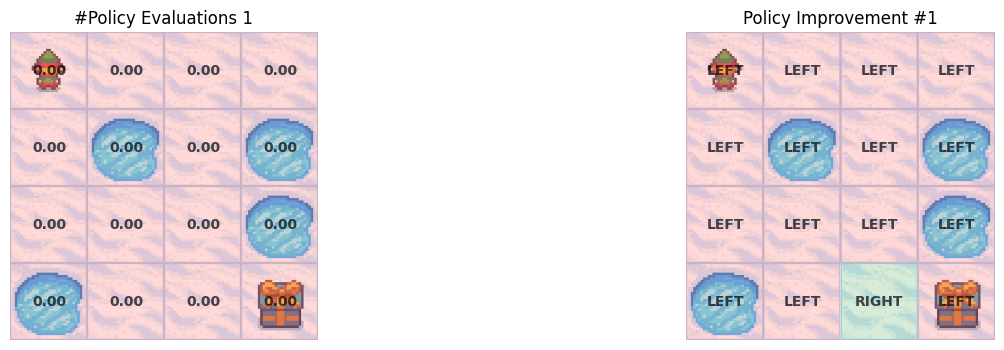

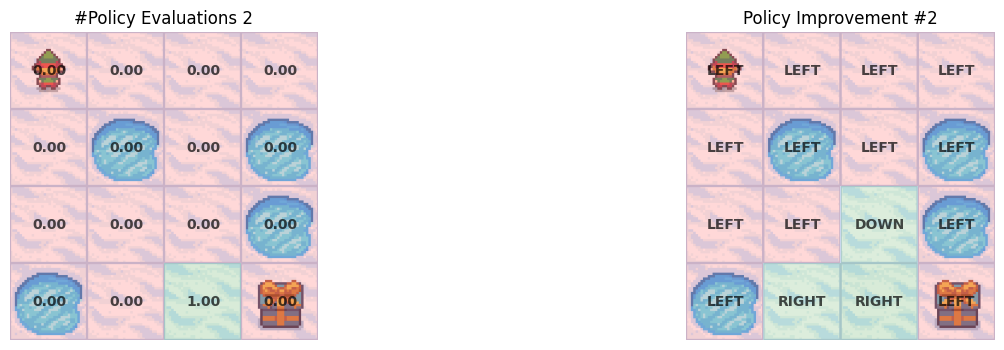

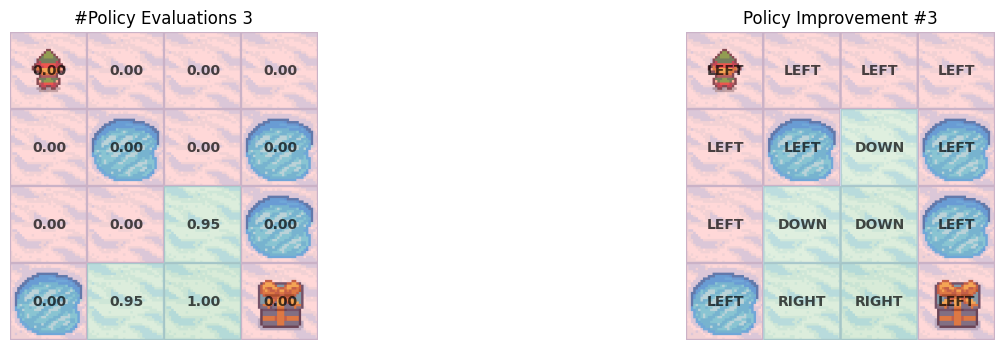

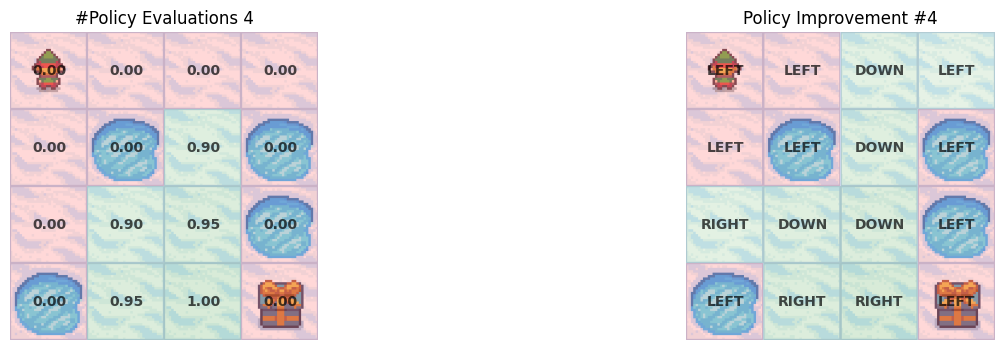

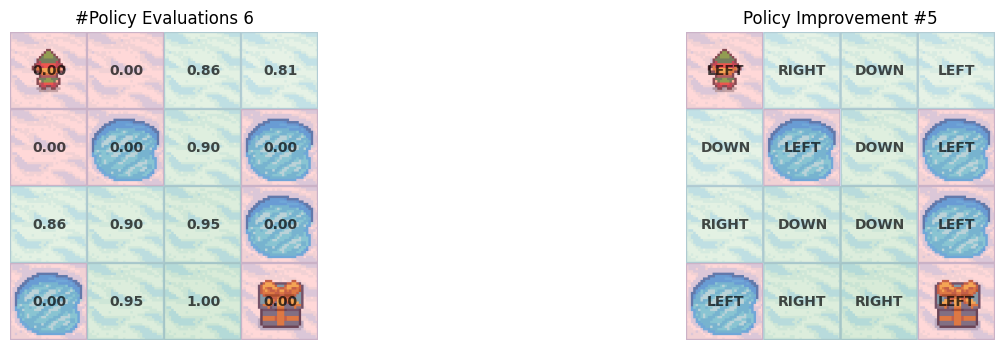

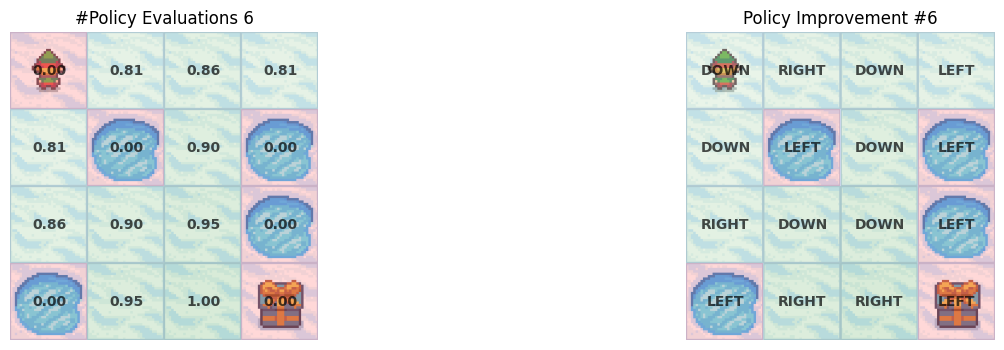

In [103]:
# Determine the optimal value function and policy given the model of the environment
policy_opt, v_opt = policy_iteration(env, DISCOUNT_FACTOR, MAX_ITERATIONS)

# Evalutate the found value function and policy given the model of the environment
policy_return = calculate_policy_return(env, policy_opt, DISCOUNT_FACTOR)
print(f"Average return of the policy: {policy_return:.2f}")

## Value Iteration

**1. Initialization:**

$ V(s) \in \mathbb{R}, \pi(s) \in A(s) \text{ arbitrarily for all } s \in S $

**2. Policy Evaluation (with maximization -> optimal value function):**

$
\begin{aligned}
& \text{Repeat} \\
& \Delta \leftarrow 0 \\
& \text{For each } s \in S: \\
& \quad v \leftarrow V^\pi(s) \\
& \quad V^\pi(s) \leftarrow \max_a \left(\mathcal{R}_s^{a}+\gamma \sum_{s^{\prime} \in \mathcal{S}} \mathcal{P}_{s s^{\prime}}^{a} V^\pi\left(s^{\prime}\right)\right) \\
& \quad \Delta \leftarrow \max(\Delta, |v - V^\pi(s)|) \\
& \text{until } \Delta < \theta \text{ (a small positive number)} \\
\end{aligned}
$


**3. Policy Inference:**

$
\begin{aligned}
& \text{Output a deterministic policy, } \pi \approx \pi^*, \text{ such that} \\
& \pi(s) = \text{argmax}_a\left(\mathcal{R}_s^{a}+\gamma \sum_{s^{\prime} \in \mathcal{S}} \mathcal{P}_{s s^{\prime}}^{a} V^\pi\left(s^{\prime}\right)\right) \\
\end{aligned}
$

### Algorithm
**TODO:**
Add the missing calculations for the *expected_reward* the *expected_discounted_return*, *v[s]* and *policy[s]*.

In [104]:
def value_iteration(
    env, discount_factor: float, max_iterations: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Value-Iteration algorithm"""
    # STEP 1
    # Initialize the policy with zeros
    policy = np.zeros(env.observation_space.n, dtype=int)
    for i in range(max_iterations):
        # STEP 2
        ### TODO: Evaluate the current policy until convergence of the value function
        v, iteration = policy_evaluation(
            env, policy, discount_factor, DPType.VALUE_ITERATION
        )
        ### TODO: Define the new policy
        new_policy = policy_improvement(env, v, policy, discount_factor)

        if np.all(policy == new_policy):
            print(f"Policy-Iteration converged at iteration #{i}")
            break

        # Plot the current policy
        new_v, _ = policy_evaluation(
            env, new_policy, discount_factor, DPType.POLICY_ITERATION
        )
        _, ax = plt.subplots(1, 2)
        visualize_v(env, v, ax[0], f"#Policy Evaluations {iteration}")
        visualize_p(
            env, new_v, new_policy, Action, ax[1], f"Policy Improvement #{i + 1}"
        )
        policy = new_policy
    return policy, v

Run the algorithm and evaluate the result.

Policy-Iteration converged at iteration #1
Average return of the policy: 0.77


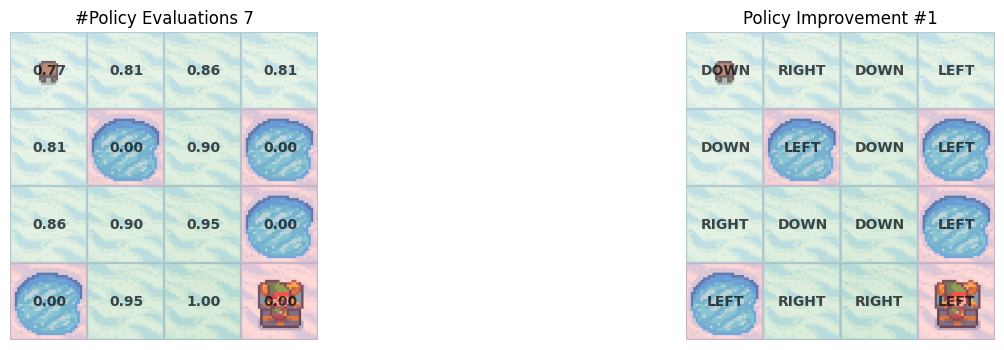

In [105]:
# Determine the optimal value function and policy given the model of the environment
policy_opt, v_opt = value_iteration(env, DISCOUNT_FACTOR, MAX_ITERATIONS)

# Evalutate the found value function and policy given the model of the environment
policy_return = calculate_policy_return(env, policy_opt, DISCOUNT_FACTOR)
print(f"Average return of the policy: {policy_return:.2f}")

## Q-Learning

$
\begin{aligned}
& \text{Initialize } Q(s, a), \text{ for all } s \in S, a \in A(s), \text{ arbitrarily, and } Q(\text{terminal-state, }\cdot) = 0 \\
& \text{Repeat (for each episode):} \\
& \quad \text{Initialize } S \\
& \quad \text{Repeat (for each step of episode):} \\
& \quad \quad \text{Choose } A \text{ from } S \text{ using policy derived from } Q \text{ (e.g., } \varepsilon\text{-greedy)} \\
& \quad \quad \text{Take action } A, \text{ observe } R, S' \\
& \quad \quad Q(S, A) \leftarrow Q(S, A) + \alpha [R + \gamma \max_a Q(S', a) - Q(S, A)] \\
& \quad \quad S \leftarrow S' \\
& \quad \text{until } S \text{ is terminal}
\end{aligned}
$

### Temporal Difference Error
### $\delta_t = \underbrace{r_{t}}_{\text{reward}} + \underbrace{\gamma}_{\text{discount factor}} \cdot \underbrace{\max_{a}Q(s_{t+1}, a)}_{\text{estimate of optimal future value}} - \underbrace{Q(s_{t}, a_{t})}_{\text{estimate of optimal current value}}$

### Temporal Difference Update
### $Q^{new}(s_{t},a_{t}) \leftarrow \underbrace{Q(s_{t},a_{t})}_{\text{old value}} + \underbrace{\alpha}_{\text{learning rate}} \cdot \underbrace{\delta_t}_\text{temporal difference error}$

### Transiton Dataclass
For ease of use we define a transition dataclass that allows us to combine all the relevant information from one state to another.

In [106]:
from dataclasses import dataclass


@dataclass
class Transition:
    p: float  # priority (only needed for (prioritized) experience replay)
    s: int  # state
    a: int  # action
    s1: int  # successor state
    r: float  # reward
    td_e: float  # temporal difference error

### Replay Memory and Prioritized Experience Replay (optional)

Experience Replay and prioritization of specific experiences are common techniques to make the training more data efficient.

* [Paper - Experience Replay, 1992](https://link.springer.com/content/pdf/10.1007%2FBF00992699.pdf)
* [Paper - Prioritized Experience Replay, 2015](https://arxiv.org/abs/1511.05952)

In [107]:
class ReplayMemory:
    def __init__(self, config):
        # transitions memory
        self.transitions = []
        # size of the memory
        self.memory_size = config.memory_size
        # size of the batches
        self.batch_size = config.batch_size
        # flag for prioritized experience replay
        self.prioritized = config.prioritized

    def push(self, transition: Transition):
        # if the memory is not yet full add the new transition
        if len(self.transitions) < self.memory_size:
            heapq.heappush(self.transitions, transition)
        # if the memory is full remove the smallest transition and add the new transition
        else:
            del self.transitions[-1]
            heapq.heappush(self.transitions, transition)

    def replay(self):
        if self.prioritized:
            return heapq.nsmallest(self.batch_size, self.transitions)
        else:
            return random.sample(sorted(self.transitions), self.batch_size)

    def __len__(self):
        return len(self.transitions)

### The Q Agent
So far we have only defined simple function calls with
```python
def function_name(arg1, arg2):
    # compute something with arg1 and arg2 and return something
    if arg2 > 0:
        something = other_function(arg1) - arg2
    else:
        something = arg1
    return something
```
However for more complex tasks it is advisable to write object oriented code using classes. Classes provide a means of bundling data and functionality together. Creating a new class creates a new type of object, allowing new instances of that type to be made. Each class instance can have attributes attached to it for maintaining its state. Class instances can also have methods (defined by its class) for modifying its state.



Hence we create a class **QAgent** that incorporates all the methods needed for Q-Learning.

```python
class QAgent:
    
    def __init__(self): # constructor method that gets called when the object is being created
        
    def td_error(self): # Temporal Difference Error
        
    def td_update(self): # Temporal Difference Update
    
    def train(self, env): # Train the agent     
```

**TODO :**
Add the missing formulas for the TD-error and the TD-update.

In [108]:
class QAgent:
    def __init__(self, config):
        # Maximum length of training
        self.training_length = config.training_length
        # Maximum length of an episode
        self.episode_length = config.episode_length
        # TD error update step size
        self.learning_rate = config.learning_rate
        # Discount factor for the return calculation
        self.discount_factor = config.discount_factor

    def td_error(self, q: float, s: int, a: int, s1: int, r: float) -> float:
        """Calculates the temporal difference error given the current model and transition"""
        ### TODO: return the TD-Error for the given state, action, successor state and reward
        td_e = r + self.discount_factor * np.max(q[s1, :]) - q[s, a]
        return td_e

    def td_update(self, q: float, td_e: float) -> float:
        """Calculates the adjusted action value (q) given the td error from a single transition"""
        ### TODO: return the update for the q value given the td error and the current q value
        q = q + self.learning_rate * td_e
        return q

    def epsilon_greedy_noise(self, env, s: int, episode: int) -> Tuple[int, float]:
        epsilon = np.random.randn(1, env.action_space.n) * (1.0 / (episode + 1))
        a = np.argmax(self.q_target[s, :] + epsilon)
        return a, epsilon

    def epsilon_greedy_linear(self, env, s: int, episode: int) -> Tuple[int, float]:
        epsilon = 1 - (episode + 1) / self.training_length
        if epsilon > np.random.rand():
            a = np.random.randint(env.action_space.n)
        else:
            a = np.argmax(self.q_target[s, :])
        return a, epsilon

    def train(self, env):
        # Initialize the model / q table with zeros/random
        self.q = np.zeros([env.observation_space.n, env.action_space.n])
        # Create a target model / q table
        self.q_target = self.q

        ### METRICS
        # create lists to contain various metrics that should be tracked during the training process
        self.metrics = {
            "return": np.zeros(self.training_length),
            "q_avg": np.zeros(self.training_length),
            "epsilon": np.zeros(self.training_length),
            "td_error": np.zeros(self.training_length),
        }

        for episode in range(self.training_length):
            # Reset the environment and retrieve the initial state
            s, _ = env.reset()
            # Set the 'done' flag to false
            d = False
            # Set the step of the episode to 0
            step = 0
            # Start the Q-Learning algorithm
            while step < self.episode_length:
                # Derive action from current policy (epsilon_greedy noise)
                a, epsilon = self.epsilon_greedy_noise(env, s, episode)

                # Execute the action and generate a successor state as well as receive an immediate reward
                s1, r, d, _, _ = env.step(a)

                # Calculate the temporal difference error
                td_e = self.td_error(self.q_target, s, a, s1, r)

                # Create a transition tuple
                transition = Transition(-(td_e + 0.001), s, a, s1, r, td_e)

                # Update model / q table
                self.q[s, a] = self.td_update(self.q_target[s, a], td_e)

                # Assign the current state the value of the successor state
                s = s1

                # Increment the step
                step += 1

                ### METRICS
                # Accumulate the episode return
                self.metrics["return"][episode] += self.discount_factor**step * r
                # Track the temporal difference error
                self.metrics["td_error"][episode] += td_e
                # Track the max epsilon values
                self.metrics["epsilon"][episode] += np.max(epsilon)
                # Track the average q values
                self.metrics["q_avg"][episode] = np.average(self.q)

                # If we reached a terminal state abort the while loop reset the environment and start over
                if d == True or step == 100:
                    # At the end of the episode update the target model with the current model

                    self.q_target = self.q

                    ### METRICS
                    self.metrics["epsilon"][episode] /= step
                    self.metrics["q_avg"][episode] /= step
                    self.metrics["td_error"][episode] /= step
                    break

### Configuration Tuple
For ease of use we define a configuration dataclass that allows us to combine all the relevant configuration from into one object.

In [109]:
@dataclass
class ConfigQAgent:
    learning_rate: float
    training_length: int
    episode_length: int
    discount_factor: float

### Configure and Train the Agent


In [110]:
config_q_agent = ConfigQAgent(
    learning_rate=0.1,
    training_length=400,
    episode_length=50,
    discount_factor=DISCOUNT_FACTOR,
)

q_agent = QAgent(config_q_agent)
q_agent.train(env)

#### Helper Functions to Compute Value Function and Policy

- `compute_v_from_q`:
Given a state-action value function $q$ (represented as a matrix), the state value function $v$ is computed for each state $s$:

$ v(s) = \max_{a} q(s, a) $

where $ a $ denotes the action.

- `compute_policy_from_q`:
Given the same state-action value function $ q $, the policy function $ \pi $ for each state $ s $ is computed as:

$ \pi(s) = \arg\max_{a} q(s, a) $

where $ \arg\max $ returns the action $ a $ that maximizes the value of $ q(s, a) $.

In [111]:
def compute_v_from_q(env, q: np.ndarray) -> float:
    """Compute the v function given the q function, maximizing over the actions of a given state."""
    # Initialize the state-value function to zero
    v = np.zeros(env.observation_space.n)
    for s in range(env.observation_space.n):
        # The (optimal) state-value function is the maximum of the q function over the actions
        v[s] = np.max(q[s, :])
    return v


def compute_policy_from_q(env, q: np.ndarray) -> np.ndarray:
    """Compute the policy function given the q function, finding the action that yields the maximum of a given state."""
    # Initialize the policy (function) to zero (left)
    policy = np.zeros(env.observation_space.n, dtype=int)
    for s in range(env.observation_space.n):
        # The (optimal) policy (function) is the action that yields the maximum of the q function over the actions
        policy[s] = np.argmax(q[s, :])
    return policy

### Visualize Metrics

Average return: 0.77
Score over time: 0.37


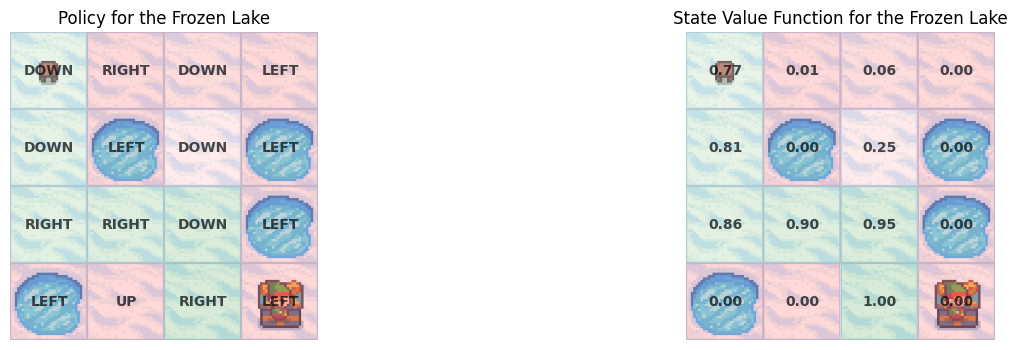

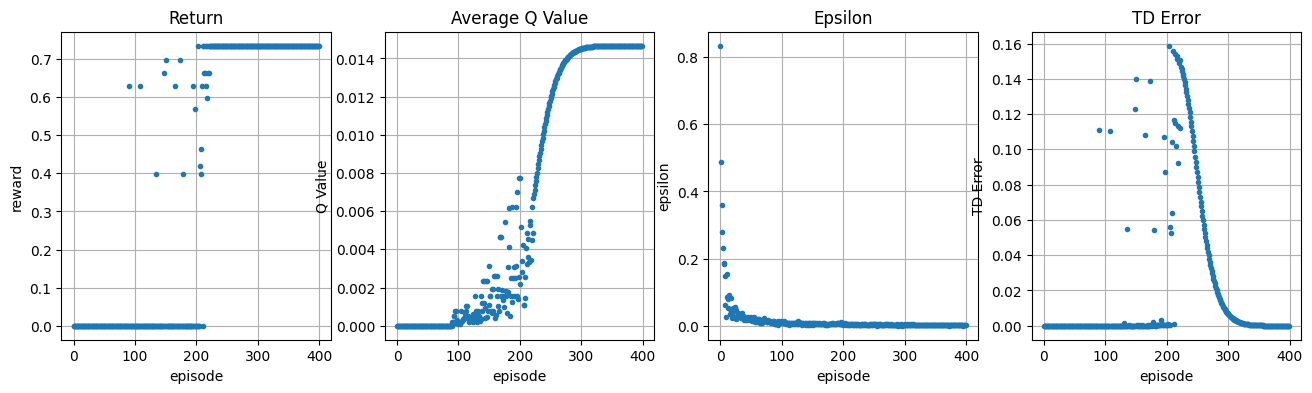

In [112]:
policy = compute_policy_from_q(env, q_agent.q_target)
v = compute_v_from_q(env, q_agent.q_target)

print(
    f"Average return: {calculate_policy_return(env, policy, q_agent.discount_factor):.2f}"
)
print(
    f"Score over time: {sum(q_agent.metrics['return']) / q_agent.training_length:.2f}"
)

fig, axi = plt.subplots(1, 2)
visualize_p(env, v, policy, Action, axi[0], title="Policy for the Frozen Lake")
visualize_v(env, v, axi[1], title="State Value Function for the Frozen Lake")

fig, ax = plt.subplots(1, 4)
# Plot the return over time
ax[0].plot(range(q_agent.training_length), q_agent.metrics["return"], ".")
ax[0].set(xlabel="episode", ylabel="reward", title="Return")
ax[0].grid()

# Plot the Q value over time
ax[1].plot(range(q_agent.training_length), q_agent.metrics["q_avg"], ".")
ax[1].set(xlabel="episode", ylabel="Q Value", title="Average Q Value")
ax[1].grid()

# Plot the epsilon over time
ax[2].plot(range(q_agent.training_length), q_agent.metrics["epsilon"], ".")
ax[2].set(xlabel="episode", ylabel="epsilon", title="Epsilon")
ax[2].grid()

# Plot the td error over time
ax[3].plot(range(q_agent.training_length), q_agent.metrics["td_error"], ".")
ax[3].set(xlabel="episode", ylabel="TD Error", title="TD Error")
ax[3].grid()

### Evaluate different Hyperparameters (optional)

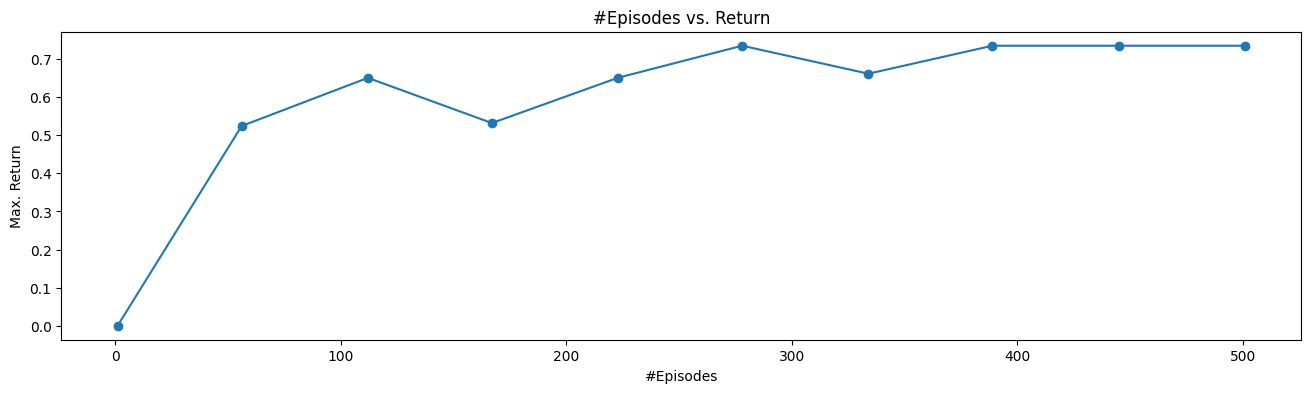

In [113]:
def evaluate_training_episodes(number_evaluation_points: int, number_evaluations: int):
    """Evaluate the training process for different number of training episodes"""
    training_lengths = np.linspace(1, 501, number_evaluation_points, dtype=int)
    returns = np.zeros(number_evaluation_points)
    for i in range(number_evaluation_points):
        config_q_agent = ConfigQAgent(
            learning_rate=0.1,
            training_length=training_lengths[i],
            episode_length=100,
            discount_factor=DISCOUNT_FACTOR,
        )
        for j in range(number_evaluations):
            q_agent = QAgent(config_q_agent)
            q_agent.train(env)
            returns[i] += np.max(q_agent.metrics["return"])
        returns[i] /= number_evaluations

    fig, ax = plt.subplots()
    ax.set(xlabel="#Episodes", ylabel="Max. Return", title="#Episodes vs. Return")
    ax.plot(training_lengths, returns, "-o")


evaluate_training_episodes(10, 10)

## How would you train an rl agent in reality?

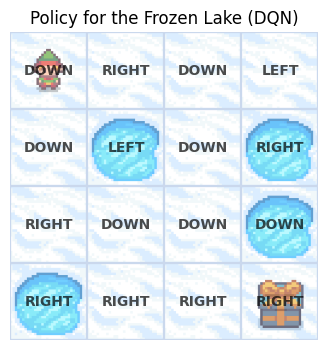

In [114]:
from stable_baselines3 import DQN

# Train the agent
model = DQN("MlpPolicy", env).learn(100000)

# Extract the policy from the model
p = np.zeros(env.observation_space.n)
for state in range(env.observation_space.n):
    p[state], _ = model.predict(state)

# Visualize the policy
_, ax = plt.subplots()
visualize_p(env, None, p, Action, ax, title="Policy for the Frozen Lake (DQN)")